In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy as sp
import pandas as pd
import scipy.stats as st
from scipy.stats import pearsonr
import os
from sklearn.metrics import auc 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# load parameters into data frame
parameters_file = r'/Users/kowens2/Downloads/estimatedIndividualParameters.txt'
parameters_df = pd.read_csv(parameters_file)

# load clustered data into data frame
data_file = r'/Users/kowens2/Documents/SARS-CoV-2 Rebound/NBACohortDec2023/NBA_6Clusters_768infections.csv'
data_df = pd.read_csv(data_file)

# load all data into data frame
full_data_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Data/NBA_1510infections.csv'
full_data_df = pd.read_csv(full_data_file)

# list unique infection IDs
IDs = list(parameters_df.id.unique())
IDs_clustered = list(data_df.ID.unique())

# Add cluster info to parameters_df
clusters2 = []
for ID in parameters_df.id.unique(): 
    if ID in list(data_df.ID):
        cluster2 = list(data_df[data_df['ID']==ID].Cluster)[0]
        clusters2.append(cluster2)
    else:
        clusters2.append(10)
parameters_df['Cluster'] = clusters2

# Define functions for pulling parameters and simulating
def GetParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i].copy()
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
        for i,(v,k) in enumerate(zip(values, keys)):
            if 'log10' in k:
                values[i] = 10**v
                keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

def Simulate(func, param_order, param_dict, init, tend, N):
    '''
    input: 
        - func is a function that takes in the state variable, time and parameters and returns the derivative
        - params is a dictionary of the parameter values 
        - init is a dictionary of the initial condition to simulate from 
    return: 
        - trajectory simulated from init for tspan using func with given params
    '''
    # make parameter list in correct order
    params = []
    for k in param_order:
        params.append(param_dict[k])
    # extract initial time
    if 'tzero' in param_dict:
        t0 = -param_dict['tzero']
    else:
        t0 = 0 
    # build tspan
    tspan = np.linspace(t0,tend,N)
    # incorporate V0
    V0 = param_dict['Vzero']
    init[4] = V0
    # simulate using scipy integrate
    y = spi.odeint(func, init, tspan, args = tuple(params))
    return tspan,y

# Put fixed paramters in a dictionary
fixed_params = dict({'c': 15, 'k':4})

T_0 = 10**7
R_0 = 0;
E_0 = 0;
I_0 = 0;
V_0 = 0;
init = [T_0, R_0, E_0, I_0, V_0]

# Write function for model simulation
def deriv(y, t, beta, phi, rho, k, delta, m, pi, c,tau):
    T,R,E,I,V = y
    
    if t > tau:
        eps = m
    else:
        eps = 0
        
    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    ddt_I = k*E - delta*I - eps*I
    if I >=1:
        ddt_V = pi*I-c*V
    else:
        ddt_V = -c*V


    return ddt_T, ddt_R, ddt_E, ddt_I, ddt_V

param_order = ['beta', 'phi', 'rho', 'k', 'delta','m', 'pi', 'c', 'tau']

# colors for plotting
colorDict = {0:'cornflowerblue',1:'forestgreen', 2:[230/255,195/255,0],3:[220/255,100/255,0],4: 'firebrick',5: 'indigo'}

## Plot average quantities from model simulation for the 6 clusters

### Simulate all individuals

In [2]:
# Simulate everyone and save output
N = 5000
X = np.zeros((len(IDs_clustered),N))
T = np.zeros((len(IDs_clustered),N))
S_ = np.zeros((len(IDs_clustered),N))
R_ = np.zeros((len(IDs_clustered),N))
E_ = np.zeros((len(IDs_clustered),N))
I_ = np.zeros((len(IDs_clustered),N))
V_ = np.zeros((len(IDs_clustered),N))

Rebound = np.zeros(len(IDs))

for count, i in enumerate(IDs_clustered ):
    ind_params = GetParams(parameters_df, i, style = 'mode')
    params_dict = {**fixed_params, **ind_params}
    tzero = -params_dict['tzero']
    t,y = Simulate(deriv, param_order, params_dict, init, 50+tzero, N);
    t = t-tzero
    S = y[:,0]
    R = y[:,1]
    E = y[:,2]
    I = y[:,3]
    V = y[:,4]
        
    X[count,:] = np.log10(np.maximum(V,200))
    T[count,:] = t
    S_[count,:] = S
    R_[count,:] = R
    E_[count,:] = E
    I_[count,:] = I
    V_[count,:] = V
    
def PlotMeanWithCI(data,df,colorDict,ylims = [], xlims = [], xlabel = 'Days relative to infection', ylabel = '',N=5000):
    plt.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize = (5,4))
    for ii in np.arange(0,6):
        data1 = data[df.Cluster == ii]
        CI_low = []
        CI_high = []
        for i in np.arange(0,N):
            ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
            CI_low.append(ans[0])
            CI_high.append(ans[1])   
        plt.fill_between(t, CI_low, CI_high,color = colorDict[ii],alpha = .2)
        plt.plot(t,np.mean(data1, axis = 0), color = colorDict[ii])
        if xlims:
            plt.xlim(xlims)
        if ylims:
            plt.ylim(ylims)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.grid() 
    plt.show()
    
def PlotByCluster(data,df,colorDict,ylims = [], xlims = [], xlabel = 'Days relative to infection', ylabel = '',N=5000):
    '''
    data: list of lists of data to include. lists should match the order of the dataframe, df
    '''
    plt.rcParams.update({'font.size': 16})
    fig,ax = plt.subplots(1,6, figsize = (18,3))
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
    for j,d in enumerate(data):
        for ii, ax in enumerate(fig.axes):
            data1 = d[df.Cluster == ii]
            CI_low = []
            CI_high = []
            for i in np.arange(0,N):
                ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
                CI_low.append(ans[0])
                CI_high.append(ans[1])   
            ax.fill_between(t, CI_low, CI_high,color = colorDict[ii],alpha = .2)
            ax.plot(t,np.mean(data1, axis = 0), color = colorDict[ii], linestyle = linestyles[j], linewidth = 3)
            if xlims:
                ax.set_xlim(xlims)
            if ylims:
                ax.set_ylim(ylims)
        #ax.set_xlabel(xlabel)
        #ax.set_ylabel(ylabel)
    for ii, ax in enumerate(fig.axes):
        ax.grid()
        
    plt.tight_layout()
    
# -- adjust time of onset of acquired immunity
adjusted_tau = [t0+tau for t0,tau in zip(parameters_df.tzero_mode,parameters_df.tau_mode)]
parameters_df['Adjusted_tau'] = adjusted_tau
# -- filter to clustered infections
clustered_df = parameters_df[parameters_df['Cluster'] <10]

### (1) Viral Load

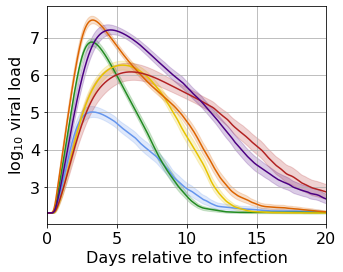

In [3]:
PlotMeanWithCI(np.log10(np.maximum(V_,200)),clustered_df,colorDict,ylims = [], xlims = [0,20], 
               xlabel = 'Days relative to infection', ylabel = r'log$_{10}$ viral load')

### (2) Infected Cells

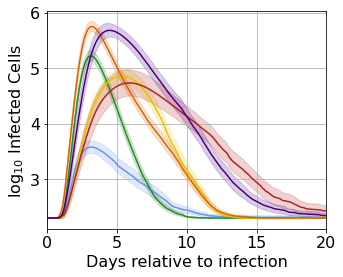

In [4]:
PlotMeanWithCI(np.log10(np.maximum(I_,200)),clustered_df,colorDict,ylims = [], xlims = [0,20], 
               xlabel = 'Days relative to infection', ylabel = r'log$_{10}$ Infected Cells')

### (4) Refractory Cells

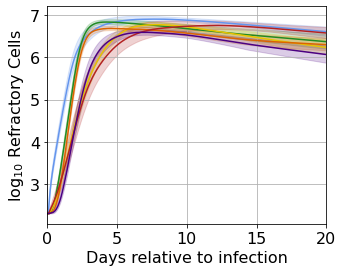

In [5]:
PlotMeanWithCI(np.log10(np.maximum(R_,200)),clustered_df,colorDict,ylims = [], xlims = [0,20], 
               xlabel = 'Days relative to infection', ylabel = r'log$_{10}$ Refractory Cells')

### (5) Susceptible cells

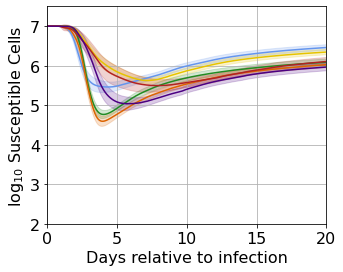

In [6]:
PlotMeanWithCI(np.log10(S_),clustered_df,colorDict,ylims = [2, 7.5], xlims = [0,20], 
               xlabel = 'Days relative to infection', ylabel = r'log$_{10}$ Susceptible Cells')

### (6) Proportion refractory cells

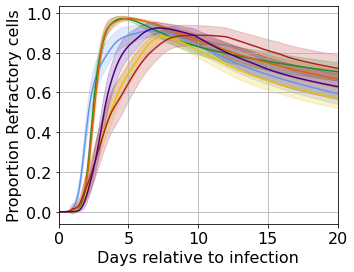

In [7]:
PlotMeanWithCI(R_/(R_+S_),clustered_df,colorDict,ylims = [], xlims = [0,20], 
               xlabel = 'Days relative to infection', ylabel = r'Proportion Refractory cells')

### (7) Dead cells


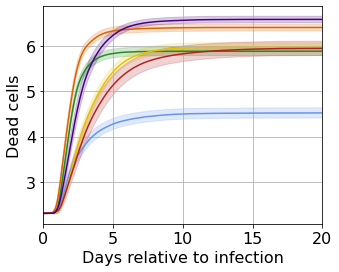

In [8]:
PlotMeanWithCI(np.log10(np.maximum(1e7 - S_-R_-I_,200)),clustered_df,colorDict,ylims = [], xlims = [0,20], 
               xlabel = 'Days relative to infection', ylabel = r'Dead cells')

### Acquired Immune Response

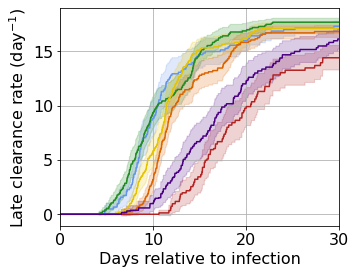

In [9]:
data = [m*1*(t > tadj) for (m,tadj) in zip(clustered_df['m_mode'],clustered_df['Adjusted_tau'])] 
data = np.concatenate(data)
data = np.reshape(data, (len(clustered_df),5000))
PlotMeanWithCI(data,clustered_df,colorDict, xlims = [0,30], ylabel = 'Late clearance rate (day$^{-1}$)')

### Clearance of infected cells by cluster

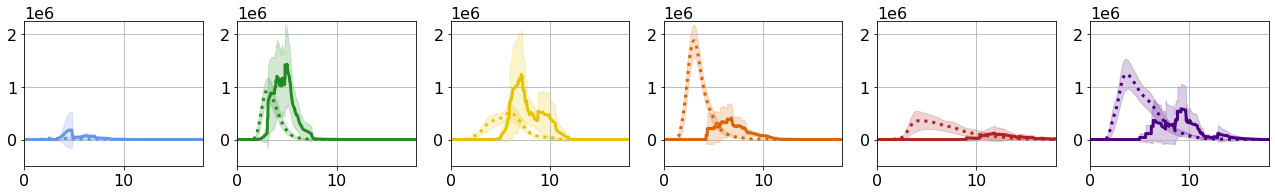

In [12]:
data = [(m*1*(t > tadj))*I for (m,tadj,I) in zip(clustered_df['m_mode'],clustered_df['tau_mode'],I_)] 
data = np.concatenate(data)
data = np.reshape(data, (len(clustered_df),5000))

data2 = [delta*I for delta,I in zip(clustered_df['delta_mode'],I_)] 
data2 = np.concatenate(data2)
data2 = np.reshape(data2, (len(clustered_df),5000))

PlotByCluster([data,data2],clustered_df,colorDict,ylims = [-.5e6, 2.25e6], xlims = [0,18], 
               xlabel = 'Days relative to infection', ylabel = r'log$_{10}$ viral load')

### Conversion of susceptible cells to refractory state by cluster

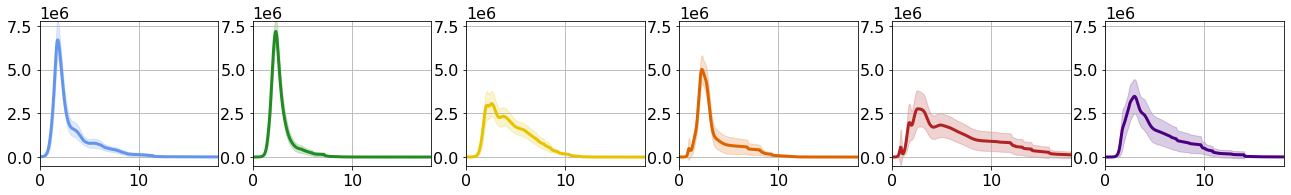

In [13]:
data = [(10**phi)*I*S for phi,I,S in zip(clustered_df['log10phi_mode'],I_,S_)] 
data = np.concatenate(data)
data = np.reshape(data, (len(clustered_df),5000))
PlotByCluster([data],clustered_df,colorDict, xlims = [0,18],ylims = [-.5e6, 7.75e6], ylabel = 'Conversion to Refractory State (cellsday$^{-1}$)')

## Correlate model parameters to kinetic features of model simulations

In [14]:
# Extract the peak, time to peak, shedding duration and AUC from the simulated trajectories
Peaks = []
TimeToPeaks = []
AUCs = []
Durations = []
for ID in list(parameters_df.id.unique()):
        ind_params = GetParams(parameters_df, ID, style = 'mode')
        params_dict = {**fixed_params, **ind_params}
        t,y = Simulate(deriv, param_order, params_dict, init, 50, 100000)
        t0 = params_dict['tzero']
        t = t+t0
        log10V = np.log10(np.maximum(y[:,4], 280))
        ind = np.argwhere(np.flip(log10V)>np.log10(280))[0][0]
        trev = np.flip(t)
        
        Peak = np.max(log10V)
        TTP = t[np.argmax(log10V)]
        AUC = auc(t,log10V)
        duration = trev[ind]
        Peaks.append(Peak)
        TimeToPeaks.append(TTP)
        AUCs.append(AUC) 
        Durations.append(duration)
        
parameters_df['Peak'] = Peaks
parameters_df['TimeToPeak'] = TimeToPeaks
parameters_df['AUC'] = AUCs
parameters_df['Duration'] = Durations
parameters_df['LogTimeToPeak'] = [np.log10(t) for t in TimeToPeaks]

In [15]:
# include log of parameters that are lognormally distributed in data frame
logdelta = [np.log10(x) for x in parameters_df.delta_mode]
logm = [np.log10(x) for x in parameters_df.m_mode]
logV0 = [np.log10(x) for x in parameters_df.Vzero_mode]

parameters_df['logdelta'] = logdelta
parameters_df['logm'] = logm
parameters_df['logV0'] = logV0

### Pearson correlation

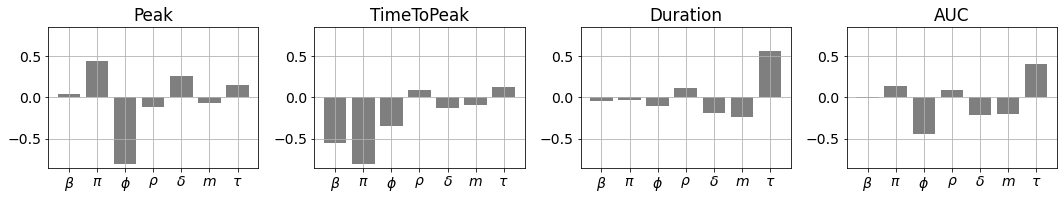

In [16]:
# Let's make a bar plot of the correlation between each parameter 
# and our 3 quantities of interest
plt.rcParams.update({'font.size': 14})

fig, ax =plt.subplots(1,4, figsize=(5*3,3))
# loop over parameters and calculate correlation
for ii,col in enumerate(['Peak', 'TimeToPeak','Duration', 'AUC']):
    y = parameters_df[col]
    slopes = []
    pvals = []
    prams = ['log10beta_mode','log10pi_mode','log10phi_mode','log10rho_mode','logdelta','logm','Adjusted_tau']
    for p in prams:
        x = parameters_df[p]
        r,p = pearsonr(x, y)
        slopes.append(r)
        pvals.append(p)
    ax[ii].bar(np.arange(0,len(slopes)),slopes, facecolor = 'tab:gray')
    ax[ii].set_ylim(-.85,.85)
    ax[ii].set_xticks(np.arange(0,len(slopes)))
    ax[ii].set_xticklabels([r'$\beta$',r'$\pi$',r'$\phi$',r'$\rho$',r'$\delta$',r'$m$',r'$\tau$'])
    ax[ii].grid()
    ax[ii].set_title(col)
    
plt.tight_layout()

### Regression model

In [17]:
import scipy as sp
import warnings
warnings.filterwarnings("ignore")

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="tab:gray", edgecolor="k", alpha = 0.3)

    return ax

def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

def ScatterPlotPlusRegressionLine(df, heights_col, weights_col, posx,posy,xlabel = 'parameter', ylabel = 'value'):
    " ScatterPlot of heights vs. weights with color according to labels"

    heights = df[heights_col]
    weights = df[weights_col]
    labels = df['Cluster']
    
    x = heights
    y = weights
    p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = equation(p, x) 

    # Statistics
    n = weights.size                                           # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = st.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                                        # residuals; diff. actual data from predicted values
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

    # Plotting --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(5,3.5))

    # Data
    for i in np.arange(0,6):
        cluster_frame = df[df.Cluster == i]
        numpts = len(cluster_frame)
        colors = [colorDict[i]]*numpts
        ax.scatter(cluster_frame[heights_col],cluster_frame[weights_col], c = colors, s=15, alpha=0.5)
    # Fit
    ax.plot(x, y_model, "-", color="k", linewidth=1.5, alpha=0.5, label="Fit")  

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = equation(p, x2)

    # Confidence Interval 
    plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean)*(y - y_mean))
    denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
    correlation_coef = numerator / denominator
    r2 = correlation_coef**2
    r2s = str(np.round(r2,2))

    # Prediction Interval
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
    ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
    ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
    ax.plot(x2, y2 + pi, "--", color="0.5")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.text(posx,posy,'$R^2$ = ' + r2s)
    plt.show()


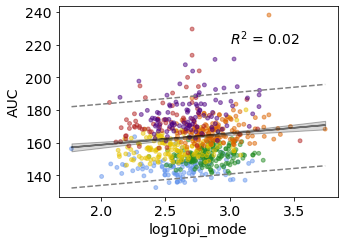

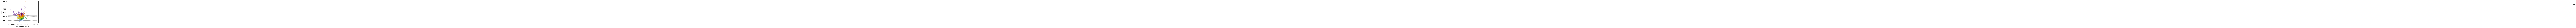

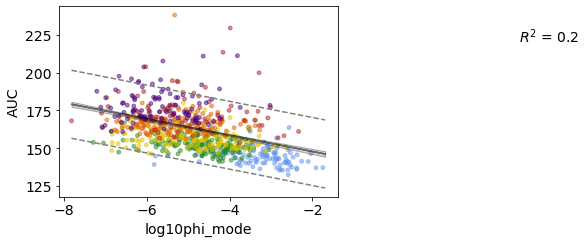

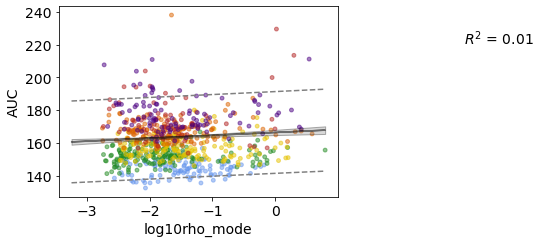

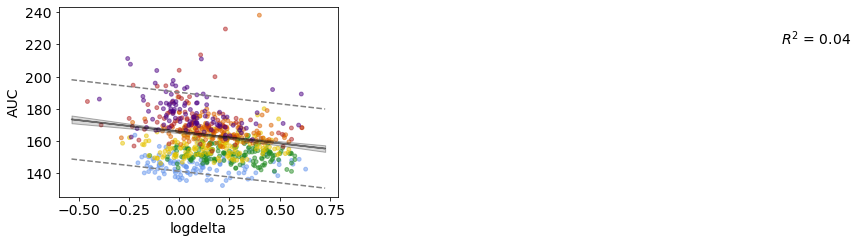

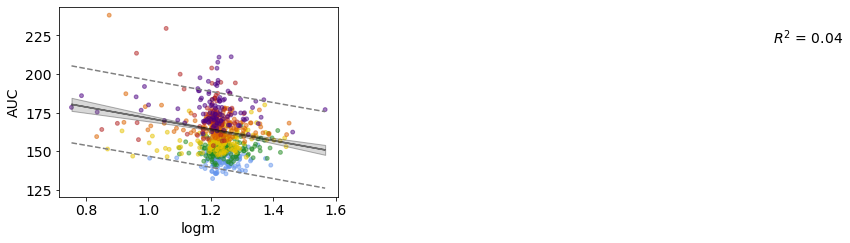

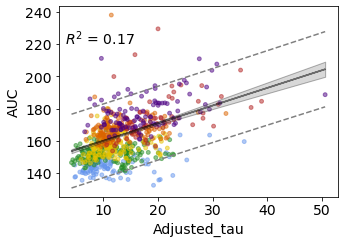

In [15]:
for param in ['log10pi_mode', 'log10beta_mode', 'log10phi_mode', 'log10rho_mode', 'logdelta','logm','Adjusted_tau']:
    ScatterPlotPlusRegressionLine(parameters_df, param, 'AUC',3,220,xlabel = param, ylabel = 'AUC')

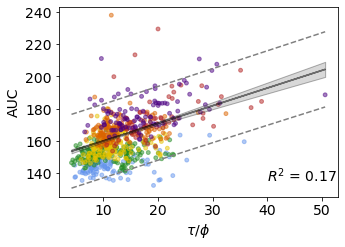

In [16]:
taum = [(10**pi*tau)/(10**phi) for (pi,tau,phi) in zip(parameters_df.log10phi_mode,parameters_df.Adjusted_tau, parameters_df.log10phi_mode)]
parameters_df['taum'] = taum
ylabel = 'AUC'
xlabel = r'$\tau/\phi$'
ScatterPlotPlusRegressionLine(parameters_df, 'taum', 'AUC',40,135, xlabel=xlabel, ylabel = ylabel)



### (1) Shedding duration

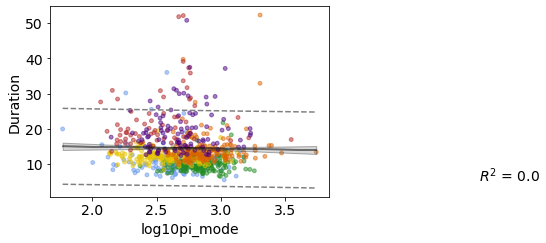

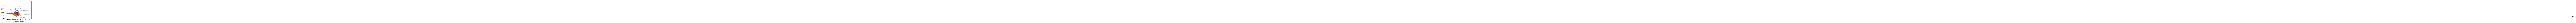

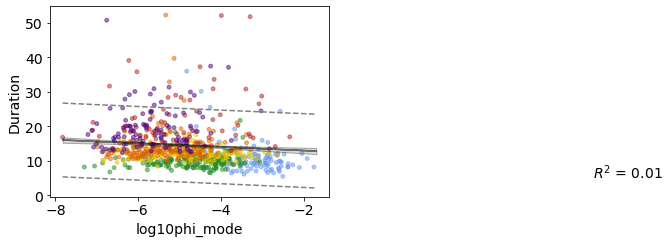

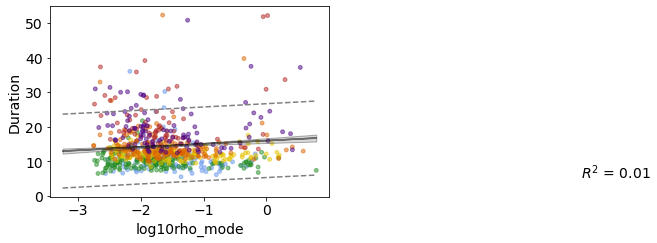

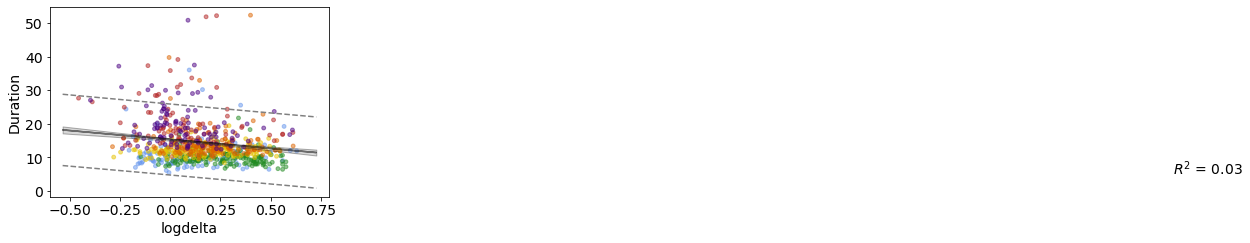

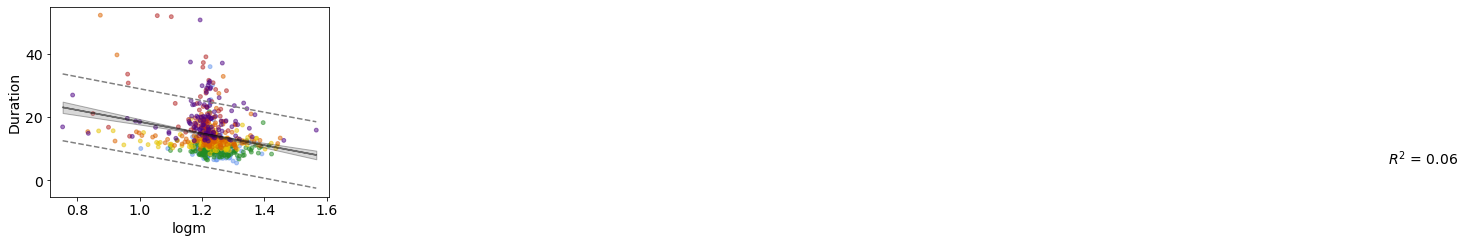

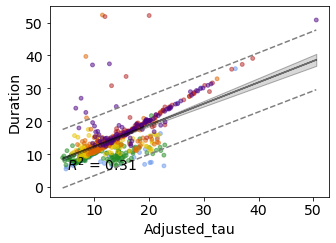

In [17]:
for param in ['log10pi_mode', 'log10beta_mode', 'log10phi_mode', 'log10rho_mode', 'logdelta','logm','Adjusted_tau']:
    ScatterPlotPlusRegressionLine(parameters_df, param, 'Duration',5,5,xlabel = param, ylabel = 'Duration')

In [61]:
## None of these look very good. If we plot the best fit line for each subgroup, the groups 0 and 5 have the best
## predictive power with R2 = 0.61.  

def ScatterPlotRegressionLines(df, heights_col, weights_col, posx,posy,xlabel = 'parameter', ylabel = 'value', partitions = [[0,1,2,3,4,5]]):
    " ScatterPlot of heights vs. weights with color according to labels"



    # Plotting --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(5,3.5))

    # Data
    for i in np.arange(0,6):
        cluster_frame = df[df.Cluster == i]
        numpts = len(cluster_frame)
        colors = [colorDict[i]]*numpts
        ax.scatter(cluster_frame[heights_col],cluster_frame[weights_col], c = colors, s=15, alpha=0.5)
        
    # Fit
    for p in partitions:
        F = [False]*len(df['Cluster'])
        for i in p:
            F = F+(df['Cluster']==i)
        df_f = df[F].copy()
        print(len(df_f))
        heights = df_f[heights_col]
        weights = df_f[weights_col]
        labels = df_f['Cluster']

        x = heights
        y = weights
        p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
        y_model = equation(p, x) 

        # Statistics
        n = weights.size                                           # number of observations
        m = p.size                                                 # number of parameters
        dof = n - m                                                # degrees of freedom
        t = st.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

        # Estimates of Error in Data/Model
        resid = y - y_model                                        # residuals; diff. actual data from predicted values
        chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
        chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
        s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error
        ax.plot(x, y_model, "-", color="k", linewidth=1.5, alpha=0.5, label="Fit")  

        x2 = np.linspace(np.min(x), 50, 100)
        y2 = equation(p, x2)

        # Confidence Interval 
        plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        numerator = np.sum((x - x_mean)*(y - y_mean))
        denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
        correlation_coef = numerator / denominator
        r2 = correlation_coef**2
        r2s = str(np.round(r2,2))
        print('$R^2$ = ' + r2s)

        # Prediction Interval
        pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
        ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
        ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
        ax.plot(x2, y2 + pi, "--", color="0.5")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.show()


217
$R^2$ = 0.61
477
$R^2$ = 0.18


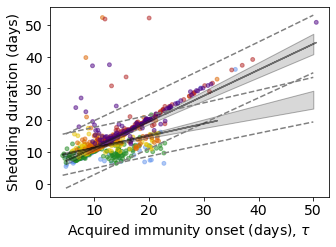

In [65]:
p = [[0,5], [1,2,3]]
ScatterPlotRegressionLines( parameters_df, 'Adjusted_tau', 'Duration',14,38, xlabel = xlabel, ylabel = ylabel, partitions = p)

### (2) Peak

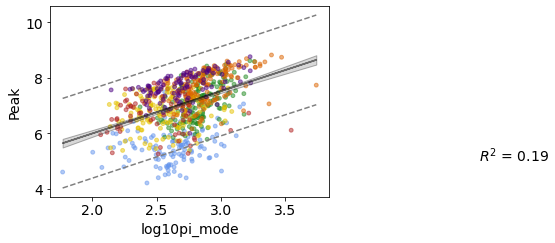

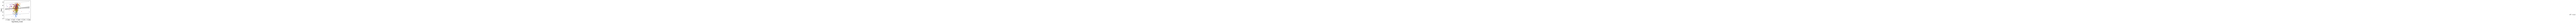

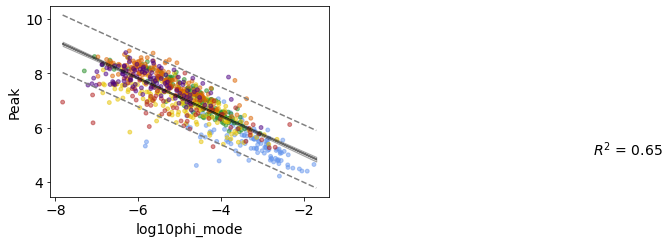

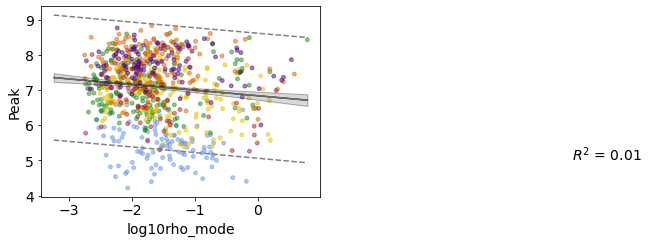

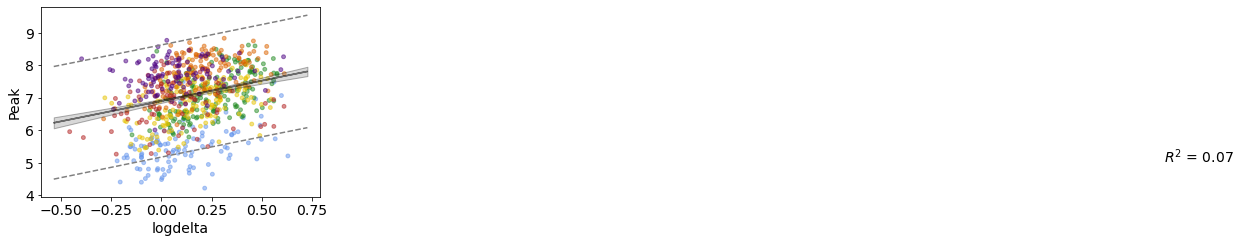

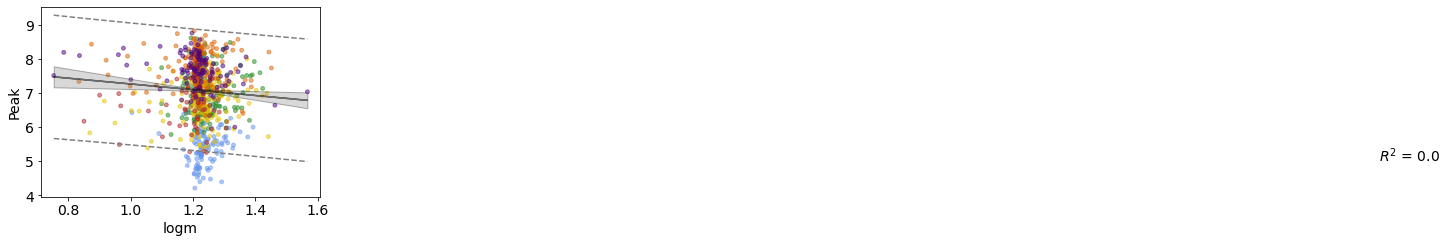

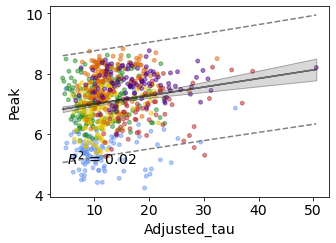

In [43]:
for param in ['log10pi_mode', 'log10beta_mode', 'log10phi_mode', 'log10rho_mode', 'logdelta','logm','Adjusted_tau']:
    ScatterPlotPlusRegressionLine(parameters_df, param, 'Peak',5,5,xlabel = param, ylabel = 'Peak')

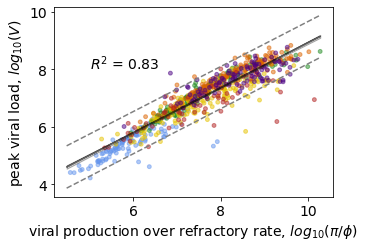

In [21]:
# Peak height is correlated with pi and inversely correlated with phi
# Combining these two we get:
piphi = [pi-phi for (pi,beta,phi) in zip(parameters_df.log10pi_mode,parameters_df.log10beta_mode,parameters_df.log10phi_mode)]
parameters_df['piphi'] = piphi
ScatterPlotPlusRegressionLine(parameters_df,'piphi', 'Peak',5,8, xlabel = r'viral production over refractory rate, $log_{10}(\pi/\phi)$', ylabel = r'peak viral load, $log_{10}(V)$')

### (3) Time to peak

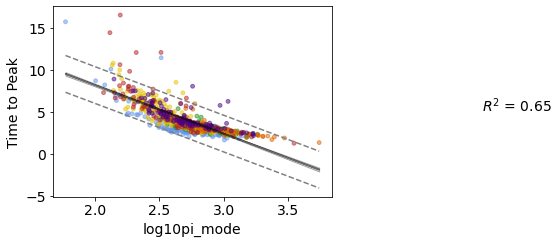

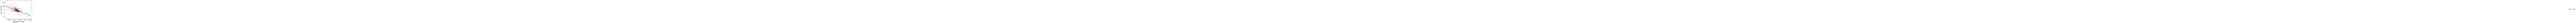

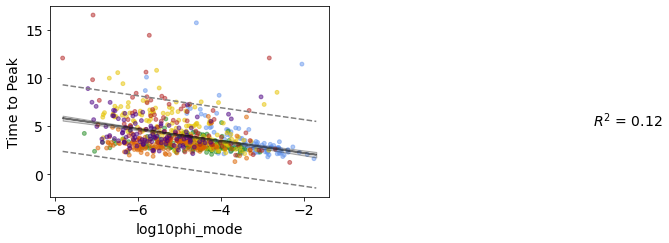

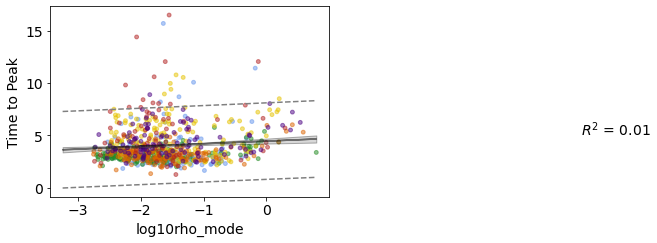

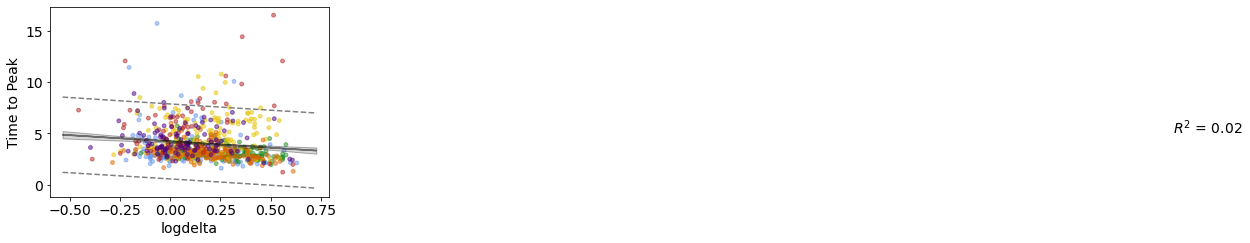

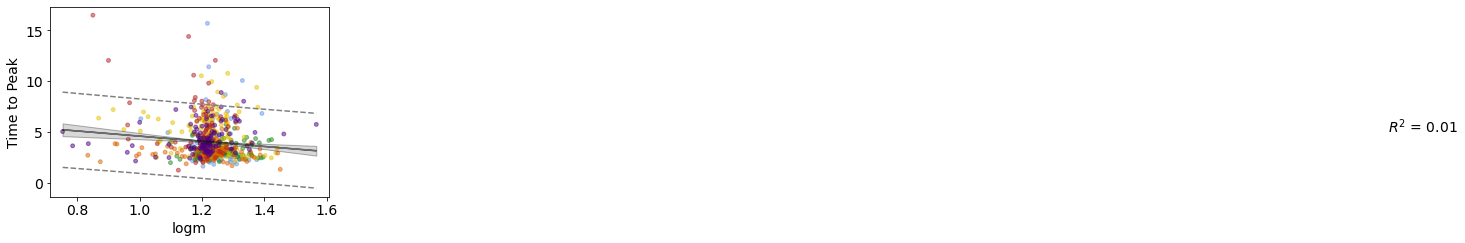

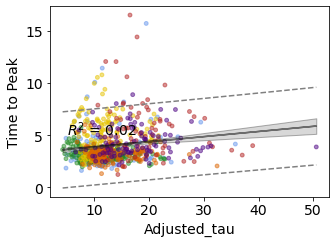

In [45]:
for param in ['log10pi_mode', 'log10beta_mode', 'log10phi_mode', 'log10rho_mode', 'logdelta','logm','Adjusted_tau']:
    ScatterPlotPlusRegressionLine(parameters_df, param, 'TimeToPeak',5,5,xlabel = param, ylabel = 'Time to Peak')

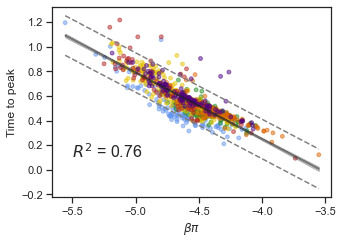

In [51]:
# Time to peak is inversely correlated with pi,beta, and phi
# Combining these we get:
pibetaphi = [beta+pi for (pi,beta,phi) in zip(parameters_df.log10pi_mode,parameters_df.log10beta_mode,parameters_df.log10phi_mode)]
parameters_df['betapi'] = pibetaphi
ScatterPlotPlusRegressionLine(parameters_df, 'betapi', 'LogTimeToPeak',-5.5,.1, xlabel=r'$\beta\pi$', ylabel = 'Time to peak')

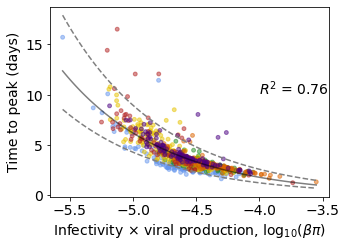

In [47]:
# Make same plot but with y axis on log scale
def ScatterPlotPlusRegressionLine(df, heights_col, weights_col,posx,posy):
    " ScatterPlot of heights vs. weights with color according to labels"
    heights = df[heights_col]
    weights = df[weights_col]
    labels = df['Cluster']
    
    x = heights
    y = weights
    p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = equation(p, x) 

    # Statistics
    n = weights.size                                           # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = st.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                                        # residuals; diff. actual data from predicted values
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

    # Plotting --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(5,3.5))

    # Data
    for i in np.arange(0,6):
        cluster_frame = df[df.Cluster == i]
        numpts = len(cluster_frame)
        colors = [colorDict[i]]*numpts
        ax.scatter(cluster_frame[heights_col],cluster_frame['TimeToPeak'], c = colors, s=15, alpha=0.5)
    # Fit
     

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = equation(p, x2)
    ax.plot(x2, 10**y2,'-', color="k", linewidth=1.5, alpha=0.5, label="Fit") 

    # Confidence Interval (select one)
    #plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
    #plot_ci_bootstrap(x, y, resid, ax=ax)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean)*(y - y_mean))
    denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
    correlation_coef = numerator / denominator
    r2 = correlation_coef**2
    r2s = str(np.round(r2,2))

    # Prediction Interval
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
    ax.fill_between(x2, 10**(y2 + pi), 10**(y2 - pi), color="None", linestyle="--")
    ax.plot(x2, 10**(y2 - pi), "--", color="0.5", label="95% Prediction Limits")
    ax.plot(x2, 10**(y2 + pi), "--", color="0.5")
    ax.set_ylabel('Time to peak (days)')
    ax.set_xlabel(r'Infectivity $\times$ viral production, log$_{10}(\beta\pi)$')
    ax.text(posx,posy,'$R^2$ = ' + r2s)
    #plt.show()
    
ScatterPlotPlusRegressionLine(parameters_df, 'betapi', 'LogTimeToPeak',-4,10)

## Compare parameter distributions for different groups

In [41]:
colors = ['cornflowerblue','forestgreen', [230/255,195/255,0],[220/255,100/255,0], 'firebrick', 'indigo']
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
order = [0,1,2,3,4,5,10]

def IndentifySignificantPairs(df, feature,threshold, pairs,myorder = order,):
    all_data = []
    for i,l in enumerate(myorder):
        temp = df[df.Cluster == l][feature]
        y = temp.tolist()
        all_data.append(y)
    output = []
    for p in pairs:
        y1 = all_data[p[0]]
        y2 = all_data[p[1]]
        if mannwhitneyu(y1,y2).pvalue < threshold:
            output.append(p)
    return(output)

def BoxPlot(df, feature, numclusters = 6, 
            ylabel = [], myorder = order, yaxis = 'linear', ylim = [], pairs = [], colors = colors):
    all_data = []
    labels = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6','N/A']
    colors = colors + ['tab:gray', 'tab:gray', 'tab:gray','tab:gray','tab:gray','tab:gray']
    sns.set(style='ticks')
    # Actual plotting
    fig = plt.figure(figsize=(4.5,6), dpi=72, facecolor="white")
    plt.rcParams.update({'font.size': 16})
    axes = plt.subplot(111)
    for i,l in enumerate(myorder):
        temp = df[df.Cluster == l][feature]
        y = temp.tolist()
        x = np.random.normal(i, 0.1, size=len(y))
        if yaxis == 'linear':
            all_data.append(y)
            plt.plot(x, y, '^',color = colors[l], alpha=0.3, markersize = 5)
        elif yaxis == 'log':
            all_data.append(np.log10(y))
            plt.plot(x, np.log10(y), '^',color = colors[l], alpha=0.3, markersize = 5)
            
    boxprops = dict(color="black",linewidth=1.5)
    medianprops = dict(color="black",linewidth=1.8)
    plt.boxplot(all_data, labels=labels,boxprops=boxprops,medianprops=medianprops,positions = np.arange(0,7));
    if ylim:
        plt.ylim(ylim)
    sns.despine(ax=axes, offset=10, trim=True)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    #plt.xlabel('dynamic cluster', fontsize = 20)
    if len(pairs) >=1:
        annotator = Annotator(axes, pairs, data=df, x='Cluster', y=feature, height = .1)
        # --- UNCOMMENT THESE TWO LINES TO PRINT UNCORRECTED PVALUES
        #annotator.configure(test="Mann-Whitney")
        #annotator.apply_and_annotate()
        # --- UNCOMMENT THESE THREE LINES TO * INDICATED PAIRS
        formatted_pvalues = ['*' for pvalue in pairs]
        annotator.set_custom_annotations(formatted_pvalues)
        annotator.annotate()
    if ylabel:
        plt.ylabel(ylabel, fontsize = 20)
        #
    else:
        plt.ylabel(feature, fontsize = 20)
    
    fig.tight_layout()
    plt.show()
    return None
all_pairs = [(0,1),(0,2),(0,3),(0,4),(0,5),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4), (3,5),(4,5)]
print('significance threshold = ', .05/(150))

significance threshold =  0.0003333333333333334


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: *
3 vs. 4: *
3 vs. 5: *
1 vs. 4: *
1 vs. 5: *
0 vs. 5: *


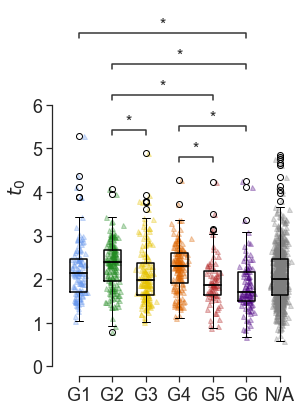

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: *
1 vs. 2: *
2 vs. 3: *
3 vs. 4: *
3 vs. 5: *
0 vs. 3: *
1 vs. 4: *
1 vs. 5: *


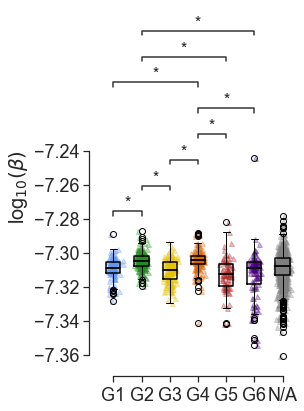

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: *
1 vs. 2: *
2 vs. 3: *
3 vs. 4: *
4 vs. 5: *
3 vs. 5: *
0 vs. 3: *
1 vs. 4: *
2 vs. 5: *
1 vs. 5: *


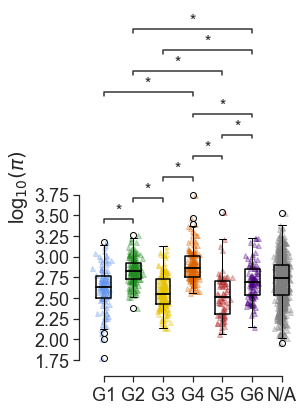

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: *
4 vs. 5: *
0 vs. 2: *
1 vs. 3: *
0 vs. 3: *
2 vs. 5: *
0 vs. 4: *
1 vs. 5: *
0 vs. 5: *


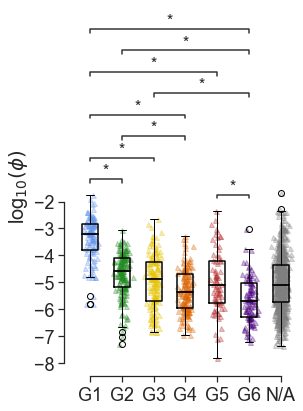

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: *
1 vs. 2: *


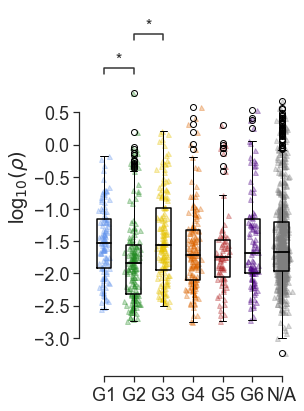

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: *
1 vs. 2: *
3 vs. 4: *
2 vs. 4: *
3 vs. 5: *
0 vs. 3: *
1 vs. 4: *
2 vs. 5: *
1 vs. 5: *


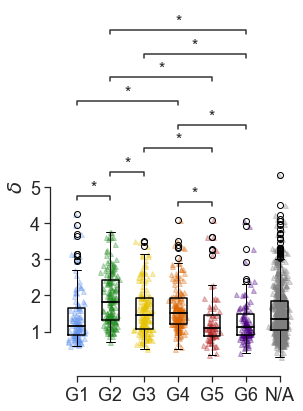

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2 vs. 4: *
1 vs. 4: *
0 vs. 4: *


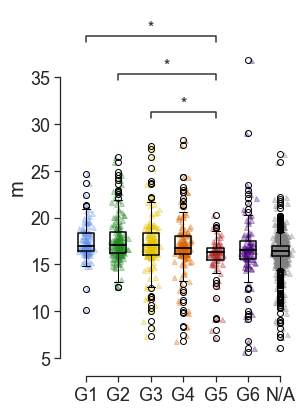

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3 vs. 4: *
1 vs. 3: *
2 vs. 4: *
3 vs. 5: *
0 vs. 3: *
1 vs. 4: *
2 vs. 5: *
0 vs. 4: *
1 vs. 5: *
0 vs. 5: *


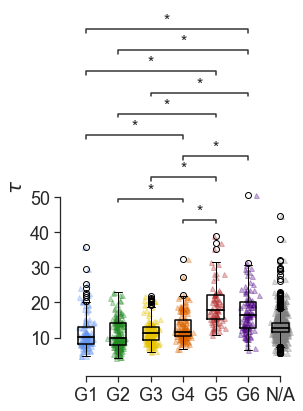

In [49]:
p = IndentifySignificantPairs(parameters_df, 'tzero_mode',.05/(150), all_pairs)
BoxPlot(parameters_df, 'tzero_mode', numclusters = 5, ylabel = r'$t_0$',ylim = [0,6],pairs = p)

p = IndentifySignificantPairs(parameters_df, 'log10beta_mode',.05/(150), all_pairs)
BoxPlot(parameters_df, 'log10beta_mode', numclusters = 5, ylabel = 'log$_{10}(\\beta)$', pairs = p)

p = IndentifySignificantPairs(parameters_df, 'log10pi_mode',.05/(150), all_pairs)
BoxPlot(parameters_df, 'log10pi_mode', numclusters = 5, ylabel = 'log$_{10}(\\pi)$', pairs = p)


p = IndentifySignificantPairs(parameters_df, 'log10phi_mode',.05/(150), all_pairs)
BoxPlot(parameters_df, 'log10phi_mode', numclusters = 5, ylabel = 'log$_{10}(\\phi)$', pairs = p)

p = IndentifySignificantPairs(parameters_df, 'log10rho_mode',.05/(150), all_pairs)
BoxPlot(parameters_df, 'log10rho_mode', numclusters = 5, ylabel = 'log$_{10}(\\rho)$',pairs = p)

p = IndentifySignificantPairs(parameters_df, 'delta_mode',.05/(150), all_pairs)
BoxPlot(parameters_df, 'delta_mode', numclusters = 5, ylabel = '$\delta$',
         pairs = p)

p = IndentifySignificantPairs(parameters_df, 'm_mode',.05/(150), all_pairs)
BoxPlot(parameters_df, 'm_mode', numclusters = 5, ylabel = r'm',pairs = p)

p = IndentifySignificantPairs(parameters_df, 'Adjusted_tau',.05/(150), all_pairs)
BoxPlot(parameters_df, 'Adjusted_tau', numclusters = 5, ylabel = r'$\tau$',pairs = p)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: *
1 vs. 2: *
2 vs. 3: *
3 vs. 4: *
4 vs. 5: *
3 vs. 5: *
0 vs. 3: *
1 vs. 4: *
2 vs. 5: *
1 vs. 5: *


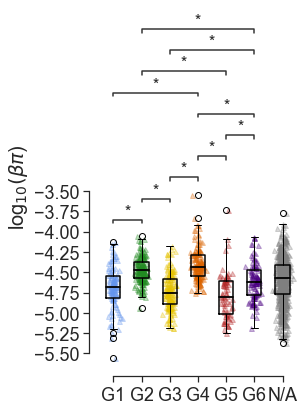

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: *
2 vs. 3: *
3 vs. 4: *
4 vs. 5: *
0 vs. 2: *
1 vs. 3: *
0 vs. 3: *
2 vs. 5: *
0 vs. 4: *
1 vs. 5: *
0 vs. 5: *


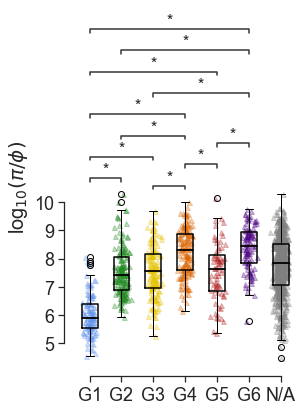

In [54]:
p = IndentifySignificantPairs(parameters_df, 'betapi',.05/(150), all_pairs)
BoxPlot(parameters_df, 'betapi', numclusters = 5, ylabel = r'log$_{10}(\beta\pi$)', pairs = p)
p = IndentifySignificantPairs(parameters_df, 'piphi',.05/(150), all_pairs)
BoxPlot(parameters_df, 'piphi', numclusters = 5, ylabel = r'log$_{10}(\pi/\phi)$', pairs = p)

## Examine correlation structure

In [55]:
cols_to_keep = ['log10beta_mode', 'log10pi_mode','log10phi_mode','log10rho_mode','logdelta','logm','Adjusted_tau', 'Cluster']
documented = parameters_df[parameters_df.Cluster < 10]
df2 = documented[cols_to_keep].copy()

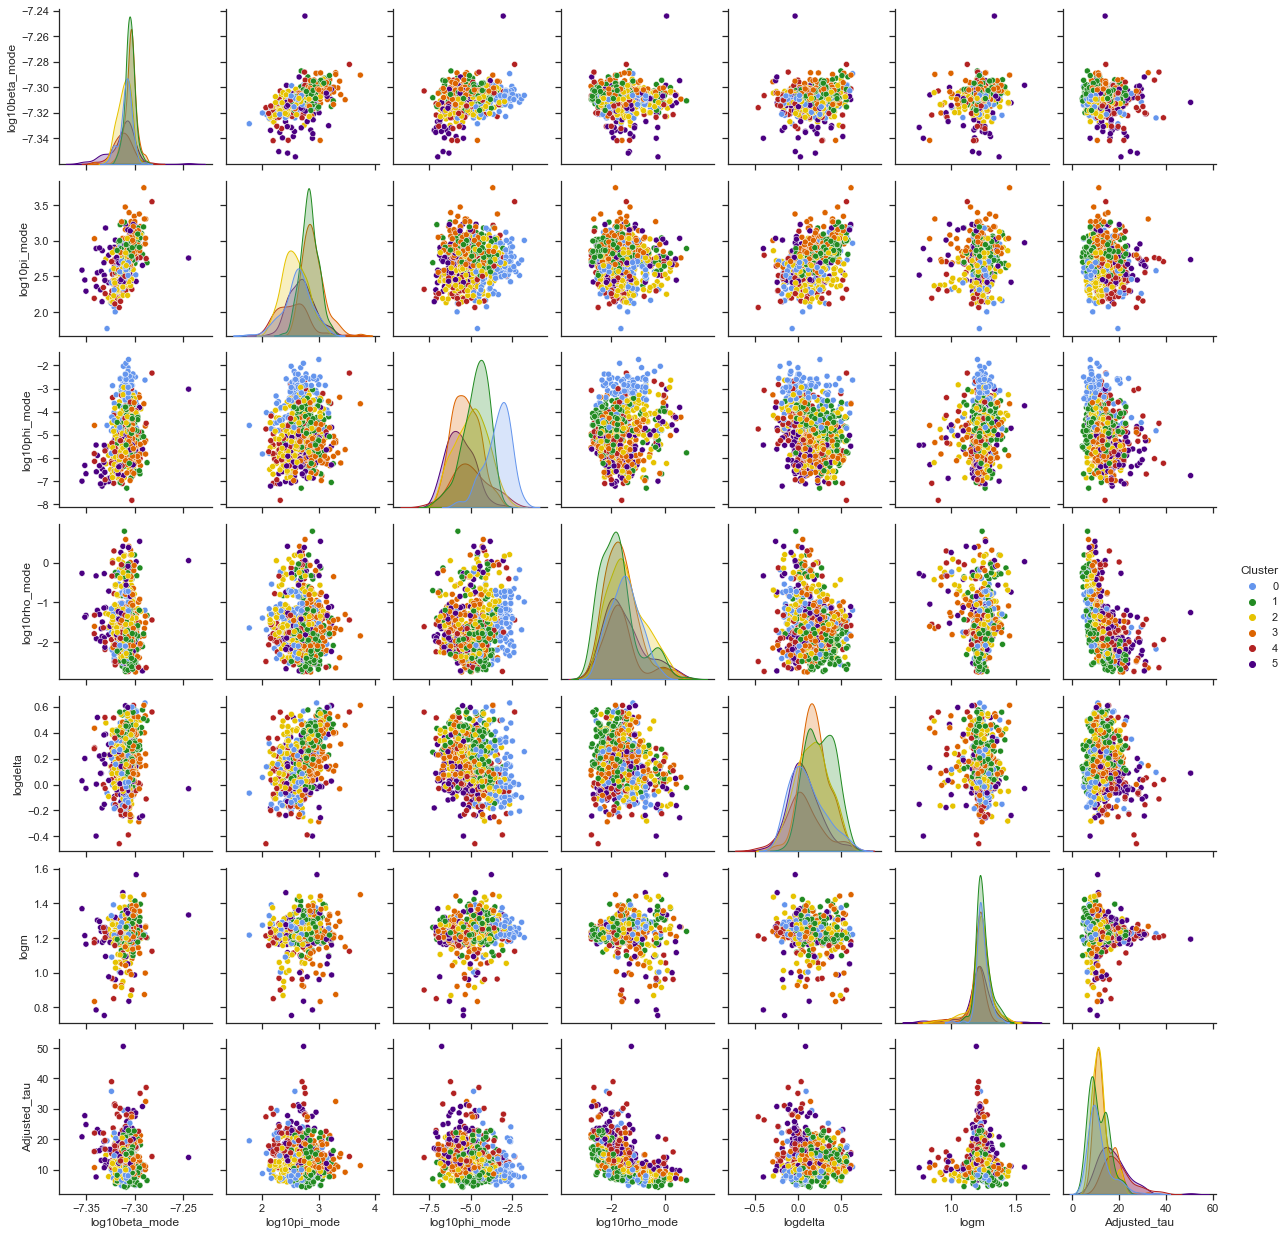

In [56]:
# Plot correlogram
import seaborn as sns
#colorsDict = {0:colors_final[0], 1:colors_final[1], 2:colors_final[2], 3:colors_final[3], 4:colors_final[4]}
sns.pairplot(df2, hue = 'Cluster', palette = colorDict)
plt.show()

In [57]:
# Print pearson correlations
df3=df2.corr()
print(df3)

                log10beta_mode  log10pi_mode  log10phi_mode  log10rho_mode  \
log10beta_mode        1.000000      0.560348       0.272628      -0.064869   
log10pi_mode          0.560348      1.000000       0.080883      -0.042166   
log10phi_mode         0.272628      0.080883       1.000000       0.152933   
log10rho_mode        -0.064869     -0.042166       0.152933       1.000000   
logdelta              0.116688      0.409280      -0.247790      -0.168669   
logm                  0.194325      0.075565       0.122471      -0.066409   
Adjusted_tau         -0.141752     -0.108935      -0.291989      -0.507297   
Cluster              -0.163518     -0.012993      -0.525546       0.022115   

                logdelta      logm  Adjusted_tau   Cluster  
log10beta_mode  0.116688  0.194325     -0.141752 -0.163518  
log10pi_mode    0.409280  0.075565     -0.108935 -0.012993  
log10phi_mode  -0.247790  0.122471     -0.291989 -0.525546  
log10rho_mode  -0.168669 -0.066409     -0.507297  0.0

### Look at correlation between random effects

In [58]:
simulated_ind_params = pd.read_csv(r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/COVID-19 Shared Resources/SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/IndividualParameters/simulatedIndividualParameters.txt')

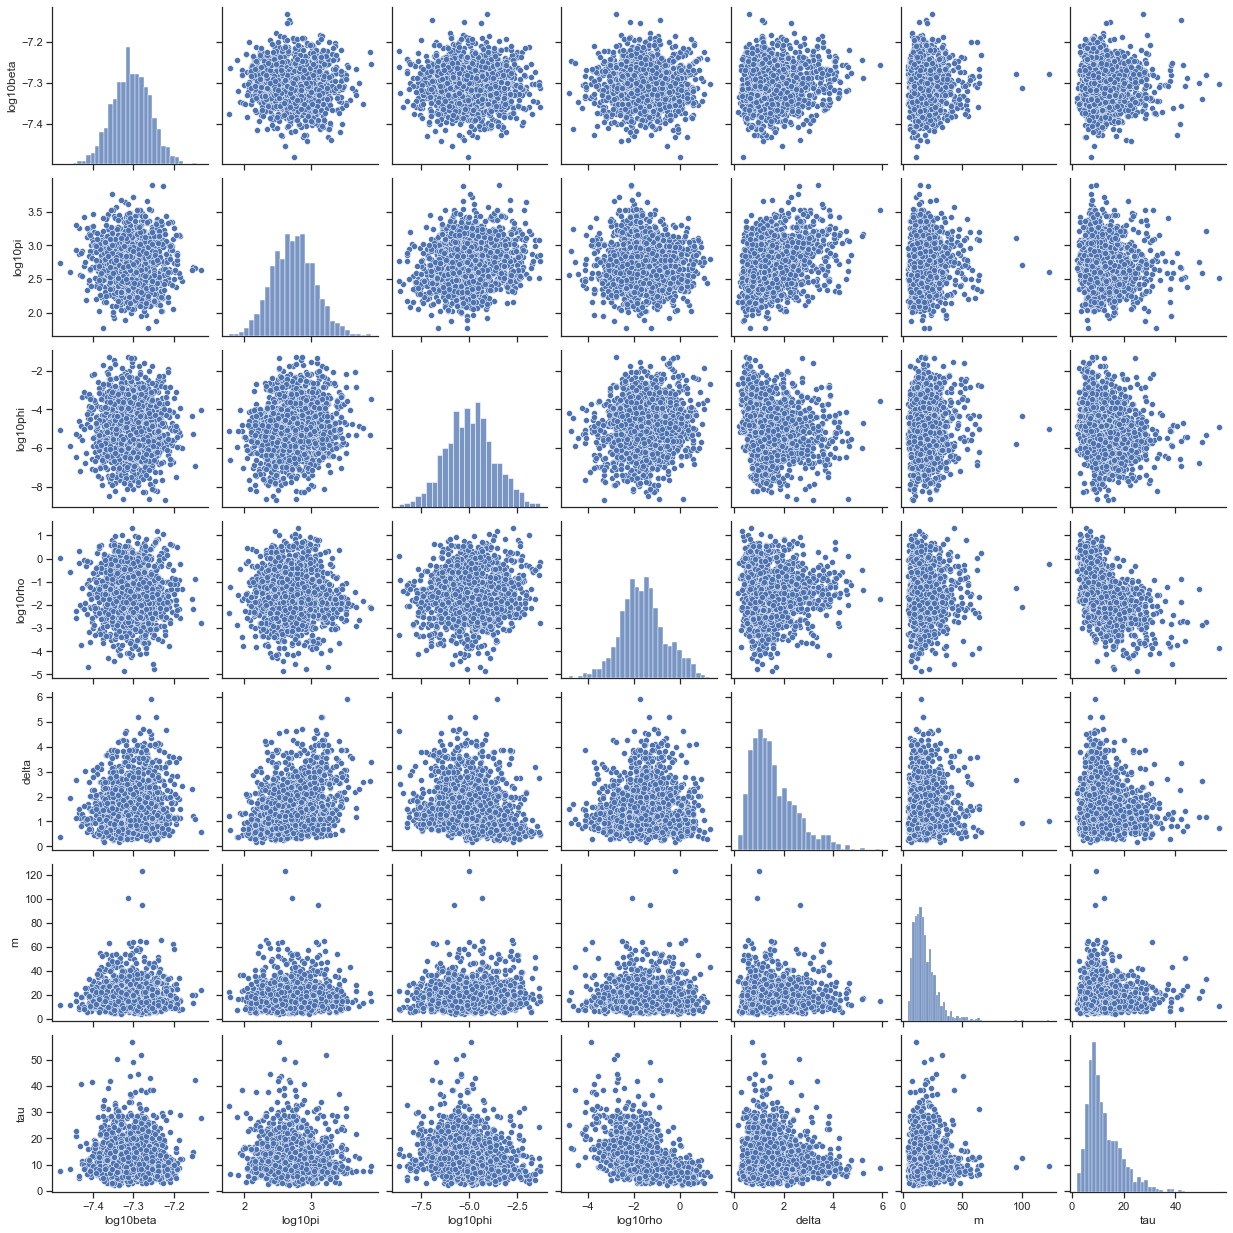

In [60]:
cols_to_keep = ['log10beta', 'log10pi','log10phi','log10rho','delta','m','tau']
df3 = simulated_ind_params[cols_to_keep].copy()

sns.pairplot(df3)
plt.show()



In [61]:
df4=df3.corr()
print(df4)

           log10beta   log10pi  log10phi  log10rho     delta         m  \
log10beta   1.000000 -0.029604 -0.024003  0.003868  0.066857  0.019804   
log10pi    -0.029604  1.000000  0.181058 -0.025991  0.323580  0.023403   
log10phi   -0.024003  0.181058  1.000000  0.114172 -0.203486  0.063069   
log10rho    0.003868 -0.025991  0.114172  1.000000  0.063714  0.013493   
delta       0.066857  0.323580 -0.203486  0.063714  1.000000 -0.036023   
m           0.019804  0.023403  0.063069  0.013493 -0.036023  1.000000   
tau        -0.034585 -0.096522 -0.221586 -0.494895 -0.093693 -0.016675   

                tau  
log10beta -0.034585  
log10pi   -0.096522  
log10phi  -0.221586  
log10rho  -0.494895  
delta     -0.093693  
m         -0.016675  
tau        1.000000  
